# Main Code

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

from utils_tools import tools
from model_arch import CNN
from process_dataset import Img_dataset
from evaluate_model import evaluate_model as eval_m


""" ***************** """
"""  Extract Dataset  """
""" ***************** """
# #------Kaggle-------
# main_dir = '../input'
# train_dir = main_dir +'/train'
# test_dir = main_dir + '/test'
# #------Kaggle-------

#------Colab--------
main_dir = '/content'
train_dir = main_dir +'/train'
test_dir = main_dir + '/test'
train_zip_dir = main_dir + '/train.zip'
test_zip_dir = main_dir + '/test.zip'
# tools.check_zip_file(train_zip_dir)
# tools.unpack_zip_file([train_zip_dir,test_zip_dir],main_dir)
#------Colab--------

size = 80
channel = 3
img_data = Img_dataset(size,channel)
# Num_classes = len(os.listdir(train_dir))
Num_classes = len(['Black-grass','Charlock','Cleavers','Common Chickweed','Common wheat','Fat Hen','Loose Silky-bent','Maize'
 ,'Scentless Mayweed','Shepherds Purse','Small-flowered Cranesbill','Sugar beet'])

Using TensorFlow backend.


Sugar beet 385 images
Charlock 390 images
Common Chickweed 611 images
Fat Hen 475 images
Small-flowered Cranesbill 496 images
Shepherds Purse 231 images
Black-grass 263 images
Loose Silky-bent 654 images
Scentless Mayweed 516 images
Cleavers 287 images
Common wheat 221 images
Maize 221 images
Note --> categories available !


---train_data image grid---


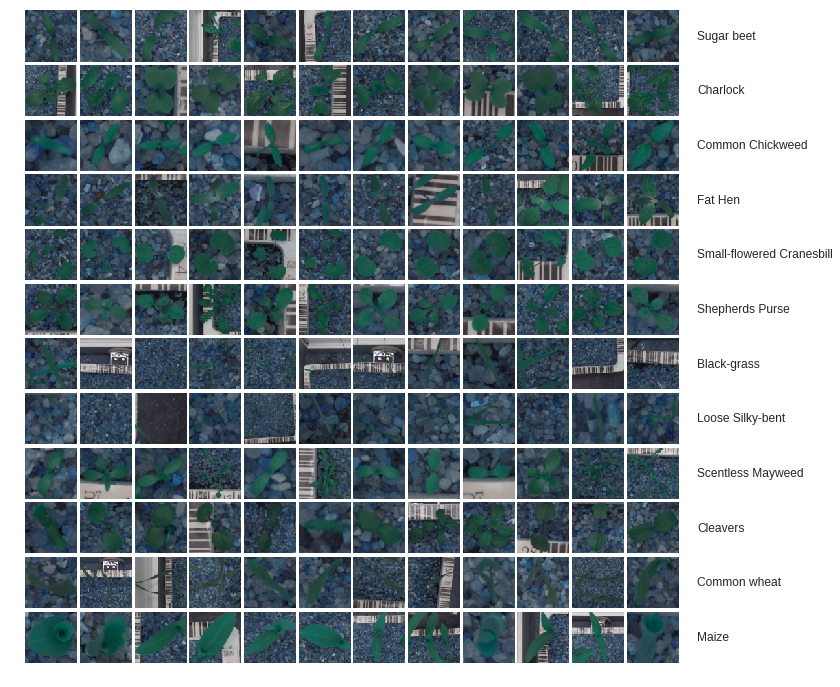

---test_data image grid---


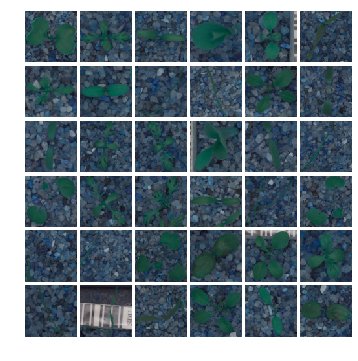



---train_data image-processing---


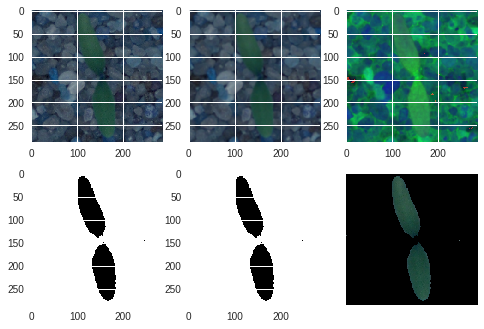

---test_data image-processing---


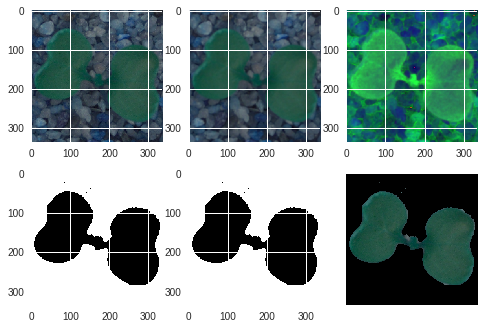



Orignal xtrain shape : (4750, 80, 80, 3)
Orignal xtest shape : (794, 80, 80, 3)


Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


Train data size : 0.68 GB
 Test data size : 0.11 GB

---Split training and validation sets---
xtrain shape : (4275, 80, 80, 3)
ytrain shape : (4275, 12)
  xval shape : (475, 80, 80, 3)
  yval shape : (475, 12)


In [3]:
""" Loading Train Data """
train_data = img_data.get_imgInfo(train_dir,have_group = True)
train_data.head()


""" Loading Test Data """
test_data = img_data.get_imgInfo(test_dir)
test_data.head()


""" Display an Image in Grid"""
print('\n')
print('---train_data image grid---')
img_data.disp_group_image(train_data)
print('---test_data image grid---')
img_data.disp_group_image(test_data,6)


""" Load Train and Test Data """
lower = (25,40,50)
upper = (75,255,255)
print('\n')
print('---train_data image-processing---')
load_xtrain = img_data.load_image(train_data,extract=True,lwr_hsv=lower,upr_hsv=upper)
print('---test_data image-processing---')
load_xtest = img_data.load_image(test_data,extract=True,lwr_hsv=lower,upr_hsv=upper)

xtrain = np.array(load_xtrain)
xtest = np.array(load_xtest)
print('\n')
print('Orignal xtrain shape : {}'.format(xtrain.shape)) #(4750, dim, dim, 3)
print('Orignal xtest shape : {}'.format(xtest.shape))


"""Normalization"""
#Pixels are represented in the range [0-255],
#but the NN converges faster with smaller values, in the range [0-1].
xtrain = xtrain/255.0
xtest = xtest/255.0


"""Label encoding target variable """
ytrain = train_data.iloc[:,2]
species = ytrain.unique()
labels = preprocessing.LabelEncoder()
labels.fit(species)
encodedlabels = labels.transform(ytrain)
print('\n')
print('Classes'+str(labels.classes_))


""" One Hot Encoding """
ytrain = to_categorical(encodedlabels)


""" Check data memory used"""
print('\n')
print('Train data size : {}'.format(tools.data_size(xtrain,'GB')))
print(' Test data size : {}'.format(tools.data_size(xtest,'GB')))


"""Split training and validation sets"""
#stratify (Classification only) :
#It in train_test_split ensures that there is no overrepresentation of classes in the val set.
#It is used to avoid some labels being overrepresented in the val set.
#Note: only works with sklearn version > 0.17
xtrain, xval, ytrain, yval = train_test_split(xtrain,ytrain, test_size=0.1,random_state=2,stratify=ytrain) # 0.1 = 10%
print('\n---Split training and validation sets---')
print('xtrain shape : {}'.format(xtrain.shape))
print('ytrain shape : {}'.format(ytrain.shape))
print('  xval shape : {}'.format(xval.shape))
print('  yval shape : {}'.format(yval.shape))


### CNN Training

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 76, 76, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 76, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       204928    
__________

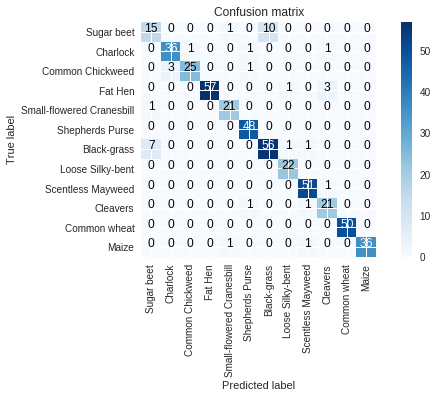

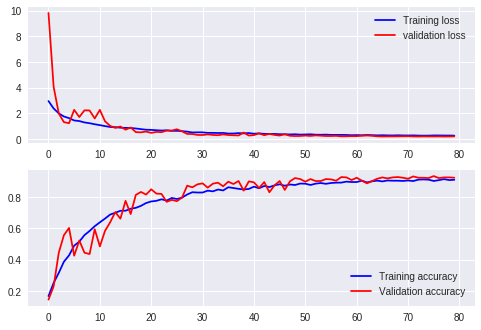

Classification report for classifier <keras.models.Sequential object at 0x7ff0d93d22b0>:
             precision    recall  f1-score   support

          0       0.65      0.58      0.61        26
          1       0.92      0.92      0.92        39
          2       0.96      0.86      0.91        29
          3       1.00      0.93      0.97        61
          4       0.91      0.95      0.93        22
          5       0.94      1.00      0.97        48
          6       0.85      0.86      0.85        65
          7       0.92      1.00      0.96        22
          8       0.94      0.98      0.96        52
          9       0.81      0.91      0.86        23
         10       1.00      1.00      1.00        50
         11       1.00      0.95      0.97        38

avg / total       0.92      0.92      0.92       475




In [4]:
"""******************"""
"""     CNN Model    """
"""******************"""

"""CNN Architechture"""
""" total_params =
(kernel_height * kernel_width * input_image_channels + 1) * number_of_filters
or
(kernel_height * kernel_width * previous filters (Channels) + 1) * number_of_filters
"""

start_time = tools.start_end_timer(None)
model = CNN.model_build(size,size,channel,Num_classes)


#"categorical_crossentropy": Error rate between the observed labels and the predicted ones
#The metric function "accuracy" is used is to evaluate the performance our model.
#Metric similar to loss function, but its result use only for evaluation.
model.compile(optimizer = 'Adam', loss = "categorical_crossentropy", metrics=["accuracy"])


"""******************"""
"""Data augmentation"""
"""******************"""
#We can make your existing dataset even larger.
#The idea is to alter the training data with small transformations
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True, # randomly flip images
        )

datagen.fit(xtrain)


"""******************"""
""" Train CNN Model  """
"""******************"""
"""Set a learning rate annealer"""
    #With the ReduceLROnPlateau function from Keras.callbacks,
    #Reduce the LR by half if the accuracy is not improved after exceed patience (epochs).
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=6,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

"""Fit the model"""
epochs = 80
batch_size = 128

history = model.fit_generator(datagen.flow(xtrain,ytrain, batch_size=batch_size),
                              epochs = epochs, validation_data = (xval,yval),
                              verbose = 2, steps_per_epoch=xtrain.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


tools.start_end_timer(start_time)


"""******************"""
"""Evaluate the model"""
"""******************"""
start_time = tools.start_end_timer(None)
Y_pred = model.predict(xval)
tools.start_end_timer(start_time)

#Return the column position where the max value is
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(yval,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
eval_m.plot_confusion_matrix(confusion_mtx, classes = species)
eval_m.plot_loss_acc_curves(history)
eval_m.Clf_report(model,Y_true,Y_pred_classes)

# Declare file name 

In [9]:
Json_name = "PSC_config_V1.json"
H_name = "PSC_weight_V1.h5"

# CNN prediction (loaded pre-trained model)

In [6]:

""" ************************ """
"""  CNN Predict Test Data   """
""" ************************ """

""" Pre-Train model"""
json_file = open(os.path.join(main_dir,Json_name), 'r')
loaded_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_json)
# load weights into new model
loaded_model.load_weights(os.path.join(main_dir,H_name))
print("Loaded model from local disk")

y_test = loaded_model.predict(xtest)

# """ Current Train Model"""
# y_test = model.predict(xtest)


submit_filename = 'CNN_PlantSeed_Classification_V4.csv'
Y_pred_classes = np.argmax(y_test,axis = 1)
Y_pred_df = labels.inverse_transform(Y_pred_classes)
results_data = pd.DataFrame(data={'file':test_data['img'], 'species':Y_pred_df})
results_data.to_csv(submit_filename, index=False)



,file,species
0,3ebbe9ca4.png,Charlock
1,969a851be.png,Scentless Mayweed
2,e1abb4ff9.png,Sugar beet
3,8170d33c1.png,Maize
4,5817b766d.png,Shepherds Purse
5,2a5064f19.png,Common wheat
6,8e29abce1.png,Scentless Mayweed
7,32c86784b.png,Common Chickweed
8,8bc0261c9.png,Loose Silky-bent
9,592473c83.png,Loose Silky-bent
